# Simulations for the Acetate Flux Branching

In [1]:
import pandas as pd
import numpy as np
import re
import os
from datetime import date

# loading matplotlib, a library for visualization
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# loading cobrapy, a library dedicated to the analysis of genome scale metabolic models
from cobra.io import read_sbml_model, write_sbml_model, save_matlab_model, save_json_model
from cobra import Reaction

from iambcodes.cobra import *

Today = date.today().strftime('%y%m%d')
FigureType = 'svg'

## Defining support functions for analysis of GSMM iUma22v1.1

In [2]:
def CoSub(Flux, Cnum, R):
    '''
    Defining the ratios of cosubstrates.
    
    Arguments:
    Flux: float, total C-mole flux
    C1: int, carbon atoms in substrate 1
    C2: int, carbon atoms in substrate 2
    R: float, flux ratio of both substrate: R = C1*F1 / (C2*F2)
    
    Return:
    F1, F2: float, molar concentrations of substrate 1 and substrate 2.
    '''
    F1 = Flux / (Cnum[0]*(1+1/R))
    F2 = F1*Cnum[0] / (R*Cnum[1])
    return F1, F2

def countCinFormula(formula):
    '''
    Counting C-atoms of metabolite in cobra model
    
    Argument:
    formula: string, the metabolite formula from the cobra model
    
    Return:
    int, number of C-atoms in formula
    '''
    return int(re.search(r'C(.*)H',formula).group(1)) if re.search(r'C(.*)H',formula).group(1) else int(1)

def set_ObjiUma(model, Product):
    '''
    Adding boundary flux for a desired product and setting the objective reaction to the product in the model.
    
    Arguments:
    model: cobra model, iUma22
    Product: string, model metabolite ID
    
    Return:
    cobra model, updated with a demand flow for the product and optimization of the new demand reaction.
    '''
    model.add_boundary(model.metabolites.get_by_id(Product), type='demand')
    model.objective = 'DM_{}'.format(Product)
    return model

def set_SubiUma(model, Sub, Flux, Ratio):
    '''
    Setting the desired substrate in the model.
    
    Arguments:
    model: cobra model, iUma22
    Sub: string/list, model metabolite ID
    Flux: float, desired substrate uptake rate
    Ratio: float, when Sub is a list, then uptake rates are balanced according to the Ratio.
    
    Return:
    cobra model, updated with designed (co-) substrate uptake rates.
    '''
    Catoms = [countCinFormula(model.metabolites.get_by_id(subi).formula) for subi in Sub]
    Cup = Flux/np.sum(Catoms)
    model.reactions.get_by_id('EX_glc__D_e').lower_bound = 0
    if len(Sub)<2:
        model.reactions.get_by_id('EX_{}'.format(Sub[0])).lower_bound = -Cup
    else:
        C1 = Catoms[0]
        C2 = Catoms[1]
        F1,F2 = CoSub(Flux, C1, C2, Ratio)
        for subi, fluxi in zip(Sub, [F1,F2]):
            model.reactions.get_by_id('EX_{}'.format(subi)).lower_bound = -fluxi
    return model

def Sim_iUma(model, CFlux, Substrates, Ratio, Objective=None):
    '''
    Simulating a model with multiple substrates

    Arguments:
    model: cobra model, iUma22
    CFlux: float, C-flux total
    Substrates: string/list, model metabolite ID
    Ratio: float, when Sub is a list, then uptake rates are balanced according to the Ratio.
    Objective (optional): string, reaction to be optimized
    
    Return:
    Flux table from model.optimize
    '''
    Catoms = [countCinFormula(model.metabolites.get_by_id(subi).formula) for subi in Substrates]
    SubFlux = CoSub(CFlux,Catoms,Ratio)
    # assuming the substrate exists as extracellular compound with exchange reaction following the syntax
    SubEX = ['EX_{}'.format(subi) for subi in Substrates]
# #     print(count)
#     count += 1
#     print('glc init:{}, ace init:{}'.format(glc_up, ace_up))
    with model as model:
        model.reactions.get_by_id(SubEX[0]).lower_bound = -SubFlux[0]
        model.reactions.get_by_id(SubEX[1]).lower_bound = -SubFlux[1]
#         model = set_ObjiUma(model, 'succ_c')
        if Objective:
            model.objective = Objective # 'EX_itacon_e'
#         print(model.summary())
        Flux = model.optimize().fluxes
#     print('glc actual:{}, ace actual:{}'.format(mySol[-1]['EX_glc__D_e'], mySol[-1]['EX_ac_e']))
#     print('Simulated total C-Flux: ',6*mySol[-1]['EX_glc__D_e'] + 2*mySol[-1]['EX_ac_e'])
# #     print(glc_up, ace_up)
    return Flux

def SimCosub(model, Exchange_dic, Objective=None):
    '''
    Simulating a model with multiple substrates

    Arguments:
    model: cobra model, iUma22
    Exchange_dic: dictionary, exchange reaction ID as keys and flux as values
    Objective (optional): string, reaction to be optimized

    Return:
    Flux table from model.optimize
    '''
    with model as model:
        model.reactions.get_by_id('EX_glc__D_e').lower_bound = 0
        [setattr(model.reactions.get_by_id(key), 'lower_bound', -value) for key, value in Exchange_dic.items()]
        if Objective:
            model.objective = Objective # 'EX_itacon_e'
        Flux = model.optimize().fluxes
    #     print('glc actual:{}, ace actual:{}'.format(mySol[-1]['EX_glc__D_e'], mySol[-1]['EX_ac_e']))
    #     print('Simulated total C-Flux: ',6*mySol[-1]['EX_glc__D_e'] + 2*mySol[-1]['EX_ac_e'])
    # #     print(glc_up, ace_up)
    return Flux


## Loading iUma22v1.1 model

In [3]:
# generating cobra variable from SBML/xml file
# assuming the base path is in 'model' of a cloned git-directory of iUma22.
ModelDir = os.path.join('..','model')
ModelFile = 'iUma22v1.1.xml'
iUmaFile = os.path.join(ModelDir,ModelFile)
model = read_sbml_model(iUmaFile)

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


## Simulations of co-substrate uptake
### Optimization to maximum growth

In [5]:
MaxGrowth = 60
CFlux = 13.2
# Acetate comes first, then glucose
SubFlux = [[ratio*CFlux/(2*100),(CFlux-ratio*CFlux/100)/6] for ratio in range(MaxGrowth+1)]
EXID = ['EX_ac_e','EX_glc__D_e']
myGrowth = list()

for Feed in SubFlux:
    ExchDict = {EXID[i]:Feed[i] for i in range(len(EXID))}
    Flux = SimCosub(model, ExchDict)
    myGrowth.append(Flux)


### Optimization to maximum ITA

In [6]:
MaxAc = 63
# Acetate comes first, then glucose
SubFlux = [[ratio*CFlux/(2*100),(CFlux-ratio*CFlux/100)/6] for ratio in range(MaxAc+1)]
Objective = 'EX_itacon_e'
EXID = ['EX_ac_e','EX_glc__D_e']
mySol = list()

for Feed in SubFlux:
    ExchDict = {EXID[i]:Feed[i] for i in range(len(EXID))}
    Flux = SimCosub(model, ExchDict, Objective)
    mySol.append(Flux)


CFlux = 13.2
Substrates = ['glc__D_e', 'ac_e']
Objective = 'EX_itacon_e'
count = 1
Samples = 25
ratio = np.logspace(2,-.2,Samples) # including solver disturbance np.logspace(1,-1,Samples), 1.5,-.2
mySol = list()

for iratio in ratio:
    Flux = Sim_iUma(model, CFlux, Substrates, iratio, Objective)
    mySol.append(Flux)



## Reformatting data
### Growth data

In [7]:
Res = list()

for indx in range(len(myGrowth)):
    Ctot = np.abs(6*myGrowth[indx]['EX_glc__D_e'] + 2*myGrowth[indx]['EX_ac_e'])
    glc = np.abs(6*myGrowth[indx]['EX_glc__D_e'])
    ace = np.abs(2*myGrowth[indx]['EX_ac_e'])
    AcTot = ace/Ctot
    bio = np.abs(myGrowth[indx]['BIOMASS_REACTION'])
    Resi = {'C-Flux': Ctot, 'Glc':glc, 'Ace':ace, 'AceRel': AcTot, 'Growth':bio} 
    Res.append(Resi.copy())
#     Res[indx][1] = np.abs(6*myGrowth[indx]['EX_glc__D_e'])
#     Res[indx][2] = np.abs(2*myGrowth[indx]['EX_ac_e'])
gres_df = pd.DataFrame(Res)
gres_df['AceProc'] = gres_df['AceRel']*100

### Ita data

In [8]:
Res = list()

for indx in range(len(mySol)):
    Ctot = np.abs(6*mySol[indx]['EX_glc__D_e'] + 2*mySol[indx]['EX_ac_e'])
    glc = np.abs(6*mySol[indx]['EX_glc__D_e'])
    ace = np.abs(2*mySol[indx]['EX_ac_e'])
    AcTot = ace/Ctot
    ita = np.abs(5*mySol[indx]['EX_itacon_e'])
    iy = ita/Ctot
    iace = ita*AcTot
    iaceY = iy*AcTot
    bio = np.abs(mySol[indx]['BIOMASS_REACTION'])
    Resi = {'C-Flux': Ctot, 'Glc':glc, 'Ace':ace, 'AceRel': AcTot, 'Ita':ita, 'Ita C-Yield':iy, 'ItaYield_x_AceRel':iaceY, 'Ita_x_AceRel':iace, 'Growth':bio} 
    Res.append(Resi.copy())
#     Res[indx][1] = np.abs(6*mySol[indx]['EX_glc__D_e'])
#     Res[indx][2] = np.abs(2*mySol[indx]['EX_ac_e'])
res_df = pd.DataFrame(Res)
res_df['AceProc'] = res_df['AceRel']*100

## Visualization of flux results

### General settings

In [9]:
RatioNumb = [0,40,62]#[22,32,43]
DataDiv = [np.arange(0,RatioNumb[0]),np.arange(RatioNumb[0],RatioNumb[1])]
# DataDiv = [np.arange(0,RatioNumb[0]),np.arange(RatioNumb[0],RatioNumb[1]),np.arange(RatioNumb[1],RatioNumb[2]),np.arange(RatioNumb[2], Samples)]
colors = ['r', 'b', 'g','c','m'] # , 'k', 'g', 'm'
msize = 100
matplotlib.rcParams.update({'font.size': 15})
# ticks inside:
# https://stackoverflow.com/questions/47873389/matplotlib-move-tick-labels-inside-plot-area

### Plot Total Carbon VS Acetate Carbon Ratio

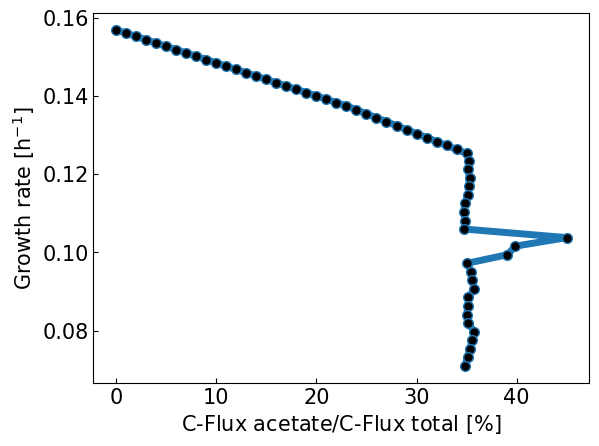

In [10]:
FigureName = 'AceRel-VS-Growth'

gres_df.plot('AceProc', 'Growth', legend=None, lw=5, marker='o', markerfacecolor='black', ms=7)
plt.xlabel('C-Flux acetate/C-Flux total [$\%$]')
plt.ylabel('Growth rate [h$^{-1}$]')
plt.tick_params(direction="in")
plt.savefig('{}_{}.{}'.format(Today,FigureName,FigureType))

plt.show()

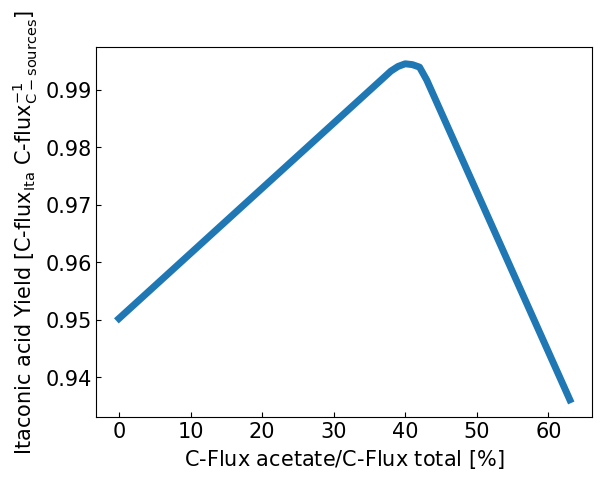

In [12]:
FigureName = 'AceRel-VS-ItaYield'

res_df.plot('AceProc', 'Ita C-Yield', legend=None, lw=5) #, marker='o', markerfacecolor='black', ms=7
plt.xlabel('C-Flux acetate/C-Flux total [$\%$]')
plt.ylabel('Itaconic acid Yield [C-flux$_{\mathrm{Ita}}$ C-flux$_{\mathrm{C-sources}}^{-1}$]')
plt.tick_params(direction="in")
plt.savefig('{}_{}.{}'.format(Today,FigureName,FigureType))

plt.show()

XVal = 'AceRel'
FigureName = 'AceRel-VS-ItaYield'
mkr_dict = {'ItaYield_x_AceRel': 'x', 'Ita C-Yield': '+'} #'replace': 'x', 'drop': 'o'
for Target in mkr_dict.keys():
    for midx, Range in enumerate(DataDiv):
        plt.scatter(res_df.iloc[Range][XVal]*100, res_df.iloc[Range][Target], 
                    s = msize, 
                    c = colors[midx], 
                    marker = mkr_dict[Target])
plt.xlabel('Acetate Carbon/ total Carbon, %')
plt.ylabel('Itaconate yield, mol/mol')
plt.tick_params(direction="in")
plt.savefig('{}_{}.{}'.format(Today,FigureName,FigureType))
plt.show()

In [15]:
RctFluxName = {'HEX1':6, 
         'G6PDH':6, 
         'MDH':4, 
         'THRALD':4,
         'TRANS-RXNTFS-7-ACET1018':2, 
         'CSNATr':2, 
         'ACONTa':6, 
         'ISOCIT-CLEAV-RXN':6, 
         'MALSm':4, 
         'SUCDH_q6_m':4, 
         'MDHm':4,
         'TRANS_Malate_Phosphate_Shuttle':4, 
         'TRANS_Cis_Aconitate_Malate_Shuttle':4, 
         'Putative_Trans_Aconitate_Decarboxylase':1, 
         'EX_co2_e':1,
         'EX_itacon_e':5}

In [17]:
for ratio in RatioNumb:
    Ctot = 6*mySol[ratio]['EX_glc__D_e']+2*mySol[ratio]['EX_ac_e']
    exp4all = mySol[ratio]/np.abs(Ctot)*100
    print('#################################################################################')
    print(f'Normalized 100 C-flux for ratio index {ratio}')
    [print(f'{model.reactions.get_by_id(Rct).id} \t {model.reactions.get_by_id(Rct).reaction} \t {round(exp4all[Rct]*RctFluxName[Rct])}') for Rct in RctFluxName.keys()];

#################################################################################
Normalized 100 C-flux for ratio index 0
HEX1 	 atp_c + glc__D_c --> adp_c + g6p_c + h_c 	 100
G6PDH 	 g6p_c + nadp_c --> 6pgl_c + h_c + nadph_c 	 0
MDH 	 mal__L_c + nad_c <=> h_c + nadh_c + oaa_c 	 -76
THRALD 	 thr__L_c --> acald_c + gly_c 	 37
TRANS-RXNTFS-7-ACET1018 	 ac_e --> ac_c 	 0
CSNATr 	 acrn_m + coa_m --> accoa_m + crn_m 	 19
ACONTa 	 cit_m <=> acon_C_m + h2o_m 	 114
ISOCIT-CLEAV-RXN 	 icit_m --> glx_m + succ_m 	 0
MALSm 	 accoa_m + glx_m + h2o_m --> coa_m + h_m + mal__L_m 	 0
SUCDH_q6_m 	 q6_m + succ_m --> fum_m + q6h2_m 	 0
MDHm 	 mal__L_m + nad_m <=> h_m + nadh_m + oaa_m 	 76
TRANS_Malate_Phosphate_Shuttle 	 mal__L_c + pi_m <=> mal__L_m + pi_c 	 0
TRANS_Cis_Aconitate_Malate_Shuttle 	 acon_C_m + mal__L_c <=> acon_C_c + mal__L_m 	 76
Putative_Trans_Aconitate_Decarboxylase 	 acon_T_c + h_c --> co2_c + itacon_c 	 19
EX_co2_e 	 co2_e <=>  	 5
EX_itacon_e 	 itacon_e -->  	 95
######################

In [ ]:
exp = 0 # 9 10 11
metid = 'acald_c' 
# itacon_c, glc__D_c, g6p_c, actp_c, cit_m, fum_m, succ_m, 2mcit_c, 2obut_c,thr__L_c,hom__L_c, asp__L_c,oaa_c, accoa_c, malcoa_c
Ctot = 6*mySol[exp]['EX_glc__D_e']+2*mySol[exp]['EX_ac_e']
exp4all = mySol[exp]/np.abs(Ctot)*100
# exp4all[flux]
print('total C-Flux: ', round(np.abs(Ctot)))
[print(f'{rct.id}\t{rct.reaction}\t{round(exp4all[rct.id])}') for rct in model.metabolites.get_by_id(metid).reactions if np.abs(exp4all[rct.id])>.1];

In [ ]:
model.reactions.get_by_id('THRALD').annotation

In [ ]:
XmlNew = os.path.join(BaseDir, 'iUma22v1.1.xml')
MatNew = os.path.join(BaseDir, 'iUma22v1.1.mat')
JsonNew = os.path.join(BaseDir, 'iUma22v1.1.json')
write_sbml_model(model, XmlNew)
save_matlab_model(model, MatNew)
save_json_model(model, JsonNew)
print('New model sbml stored as: {}'.format(XmlNew))


In [31]:
model.reactions.MDH

Reaction identifier,MDH
Name,Cytosolic MALATE-DEH-RXN
Memory address,0x07ff518654ac0
Stoichiometry,mal__L_c + nad_c <=> h_c + nadh_c + oaa_c (S)-malate + NAD+ <=> H+ + NADH + oxaloacetate
GPR,UMAG_11161
Lower bound,-1000.0
Upper bound,1000.0


In [43]:
KO = ['HISTD', 'MDH', 'TRANS_Adenine_Nucleotide_Transporter'] # , 'MDH', 'TRANS_Adenine_Nucleotide_Transporter'
[print(model.reactions.get_by_id(myKO).reaction) for myKO in KO]
GlcFlux = 38/6
AceFlux = 62/2
with model as model:
    model.reactions.get_by_id('EX_glc__D_e').lower_bound = -GlcFlux
    model.reactions.get_by_id('EX_ac_e').lower_bound = -AceFlux
    [setattr(model.reactions.get_by_id(myKO), 'bounds',[0,0]) for myKO in KO]
    # model.objective = 'EX_itacon_e'
    KOSol = model.optimize()
Ctot = 6*KOSol.fluxes['EX_glc__D_e']+2*KOSol.fluxes['EX_ac_e']
exp4all = KOSol.fluxes/np.abs(Ctot)*100
print('#################################################################################')
# print(f'Normalized 100 C-flux for ratio index {ratio}')
[print(f'{model.reactions.get_by_id(Rct).id} \t {model.reactions.get_by_id(Rct).reaction} \t {round(exp4all[Rct]*Ccount)}') for Rct,Ccount in RctFluxName.items()];

h2o_c + histd_c + 2.0 nad_c --> 3.0 h_c + his__L_c + 2.0 nadh_c
mal__L_c + nad_c <=> h_c + nadh_c + oaa_c
adp_c + atp_m --> adp_m + atp_c
#################################################################################
HEX1 	 atp_c + glc__D_c --> adp_c + g6p_c + h_c 	 99
G6PDH 	 g6p_c + nadp_c --> 6pgl_c + h_c + nadph_c 	 0
MDH 	 mal__L_c + nad_c <=> h_c + nadh_c + oaa_c 	 0
THRALD 	 thr__L_c --> acald_c + gly_c 	 0
TRANS-RXNTFS-7-ACET1018 	 ac_e --> ac_c 	 0
CSNATr 	 acrn_m + coa_m --> accoa_m + crn_m 	 2
ACONTa 	 cit_m <=> acon_C_m + h2o_m 	 6
ISOCIT-CLEAV-RXN 	 icit_m --> glx_m + succ_m 	 0
MALSm 	 accoa_m + glx_m + h2o_m --> coa_m + h_m + mal__L_m 	 0
SUCDH_q6_m 	 q6_m + succ_m --> fum_m + q6h2_m 	 3
MDHm 	 mal__L_m + nad_m <=> h_m + nadh_m + oaa_m 	 3
TRANS_Malate_Phosphate_Shuttle 	 mal__L_c + pi_m <=> mal__L_m + pi_c 	 -3
TRANS_Cis_Aconitate_Malate_Shuttle 	 acon_C_m + mal__L_c <=> acon_C_c + mal__L_m 	 0
Putative_Trans_Aconitate_Decarboxylase 	 acon_T_c + h_c --> co2_c + itaco

In [ ]:
metid = 'ac_c'
[print('{}\t{}'.format(rct.id, rct.reaction)) for rct in model.metabolites.get_by_id(metid).reactions];

In [ ]:
model.reactions.get_by_id('HISTD')

In [ ]:
# [reaction for reaction in model.metabolites.get_by_id('mal__L_c').reactions if reaction in model.metabolites.get_by_id('pyr_c').reactions]
Met1 = 'icit_c'
Met2 = 'glx_c' # 'CPD-356_c'
# print(MetSharedRcts(model,Met1, Met2)[0]) # 'shared reactions of {} and {}: {}'.format(Met1, Met2, MetSharedRcts(model,'man_c', 'MANNOSE-6P_c')))
flux = MetFluxConnect(model, Met1, Met2, slim=False)
print('possible flux between {} and {}: {}'.format(Met1, Met2, MetFluxConnect(model, Met1, Met2)))

In [ ]:
model.metabolites.get_by_id('histd_c')
# model.summary()

In [ ]:
with model as model:
    model.reactions.get_by_id('EX_glc__D_e').lower_bound = -2
    model.reactions.get_by_id('EX_ac_e').lower_bound = -4
    # model = set_ObjiUma(model, 'succ_c')
#     model.objective = 'EX_itacon_e'
    print(model.summary())
    print(model.metabolites.get_by_id('accoa_c').summary())

In [ ]:
model.reactions.get_by_id('MALSc')